In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [2]:
import os
import sys
dir_path = '/content/gdrive/My Drive/urbcomp_fall2025/assignment_1'
sys.path.append(dir_path)

In [3]:
!python --version

Python 3.11.9


In [29]:
# including modules
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import operator
import numpy as np
import geopandas as gp
%load_ext autoreload
%autoreload 2
import networkx as nx
import community
import random
from shapely.geometry import Point
from collections import Counter

sys.path.insert(0, '../utils')
import airtraffic_helpers # type: ignore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Domestics airport details
airports_df = pd.read_csv("../dataset/288804893_T_MASTER_CORD.csv".format(dir_path))
print('Shape of the dataframe:',airports_df.shape,'\n')
print('Printing one record:',airports_df[:1].T)

Shape of the dataframe: (18101, 28) 

Printing one record:                                                    0
AIRPORT_ID                                     10001
AIRPORT                                          01A
DISPLAY_AIRPORT_NAME            Afognak Lake Airport
DISPLAY_AIRPORT_CITY_NAME_FULL      Afognak Lake, AK
AIRPORT_WAC                                        1
AIRPORT_COUNTRY_NAME                   United States
AIRPORT_COUNTRY_CODE_ISO                          US
AIRPORT_STATE_NAME                            Alaska
AIRPORT_STATE_CODE                                AK
AIRPORT_STATE_FIPS                               2.0
CITY_MARKET_ID                                 30001
DISPLAY_CITY_MARKET_NAME_FULL       Afognak Lake, AK
CITY_MARKET_WAC                                    1
LAT_DEGREES                                     58.0
LAT_HEMISPHERE                                     N
LAT_MINUTES                                      6.0
LAT_SECONDS                             

In [ ]:
# Domestics airlines connections
trips_df = pd.read_csv("../dataset/288798530_T_T100D_MARKET_ALL_CARRIER.csv".format(dir_path))
print('Shape of the dataframe:',trips_df.shape,'\n')
print('Printing one record:',trips_df[:1].T)

Shape of the dataframe: (41930, 8) 

Printing one record:                                       0
UNIQUE_CARRIER                      04Q
UNIQUE_CARRIER_NAME  Tradewind Aviation
ORIGIN_AIRPORT_ID                 13535
ORIGIN                              MVL
DEST_AIRPORT_ID                   12197
DEST                                HPN
MONTH                                 1
Unnamed: 7                          NaN


In [7]:
# Extracting edges - we consider a connection from one airport to another as an edge.
# Note: these edges will be directed.
edges = list(zip(trips_df['ORIGIN_AIRPORT_ID'],trips_df['DEST_AIRPORT_ID']))

In [8]:
# creating directed and undirected graphs based on airports and their connections
G = nx.DiGraph()
G.add_edges_from(edges)
G_undirected = nx.Graph()
G_undirected.add_edges_from(edges)

In [9]:
# printing the total number of nodes and edges of directed graph
print('Total number of airports:',len(list(G.nodes)))
print('Total number of connections:',len(list(G.edges)))

Total number of airports: 894
Total number of connections: 13760


In [10]:
# creating a GeoDataframe for plotting airports on a map
airport_ids = list(G.nodes)
edgelist = list(G.edges)
geo_stations = airtraffic_helpers.get_geodataframe_airports(airports_df,airport_ids)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

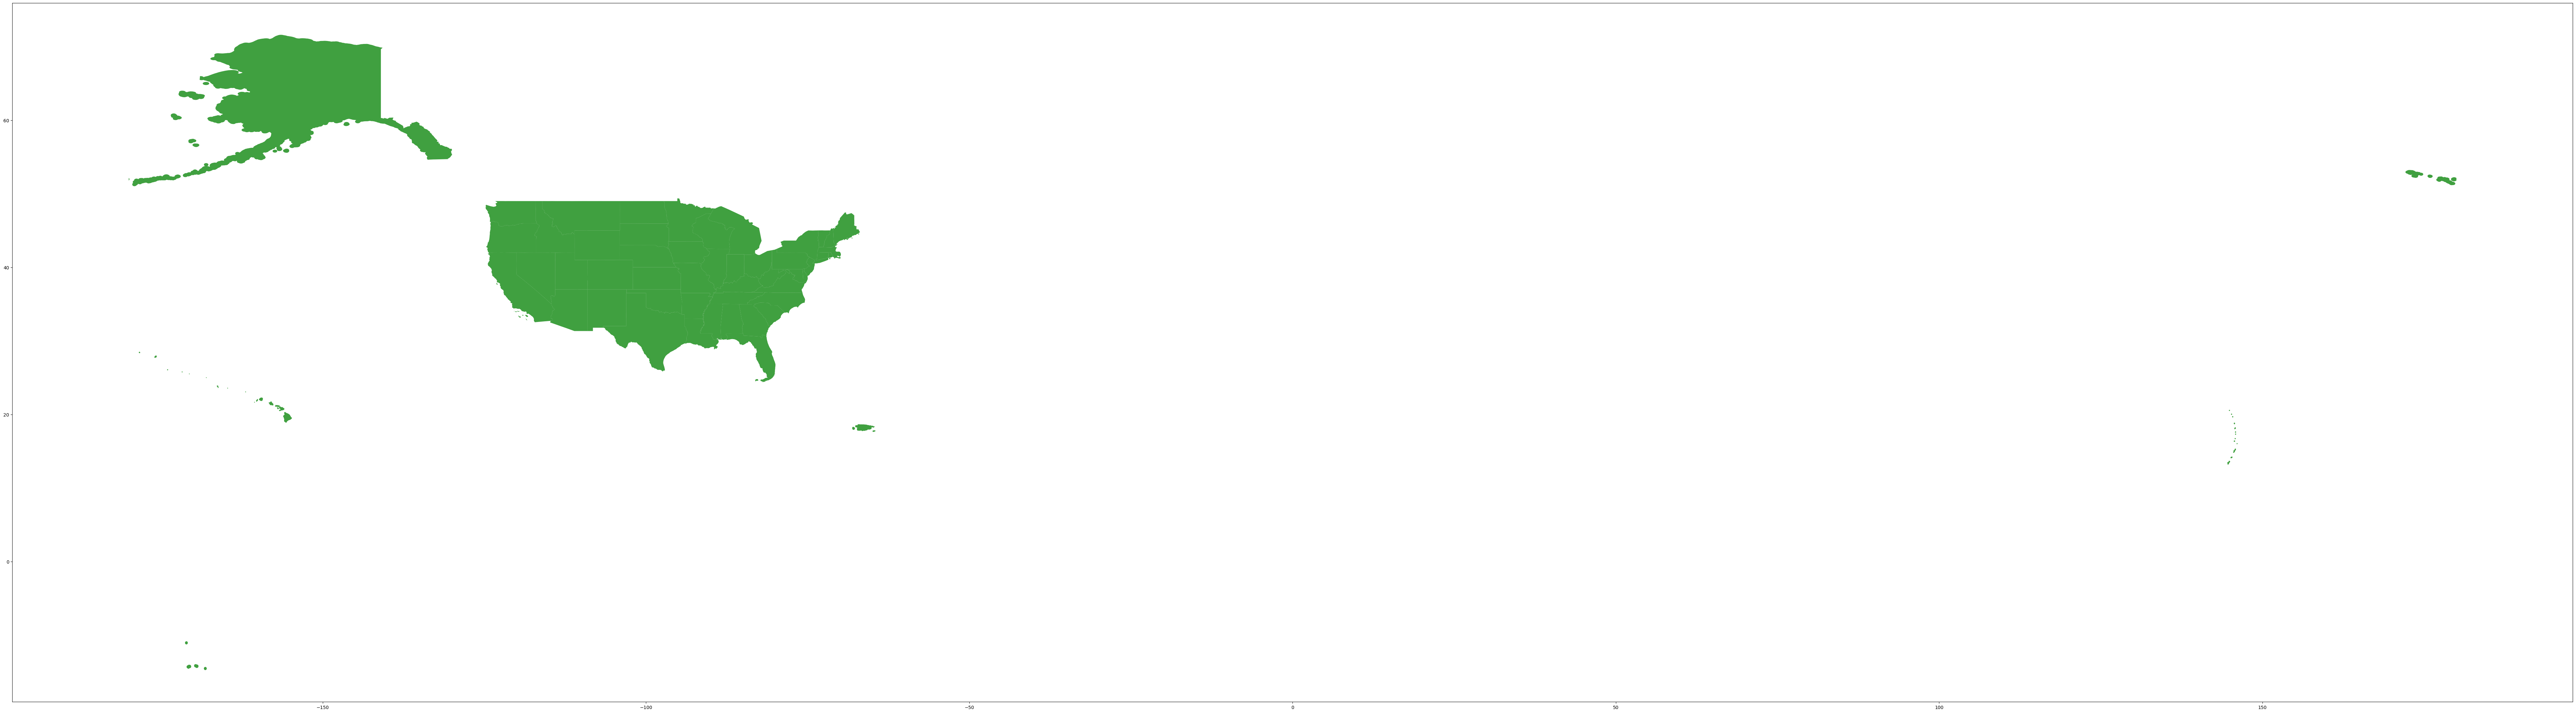

In [12]:
# reading the shape file of US
shp_us = gp.GeoDataFrame.from_file("../dataset/Igismap/Alabama_AL4_US_Poly.shp".format(dir_path))
shp_us=shp_us.to_crs({'init':'epsg:4326'})
shp_us.plot(figsize=(100,100),color='g',alpha=0.75)

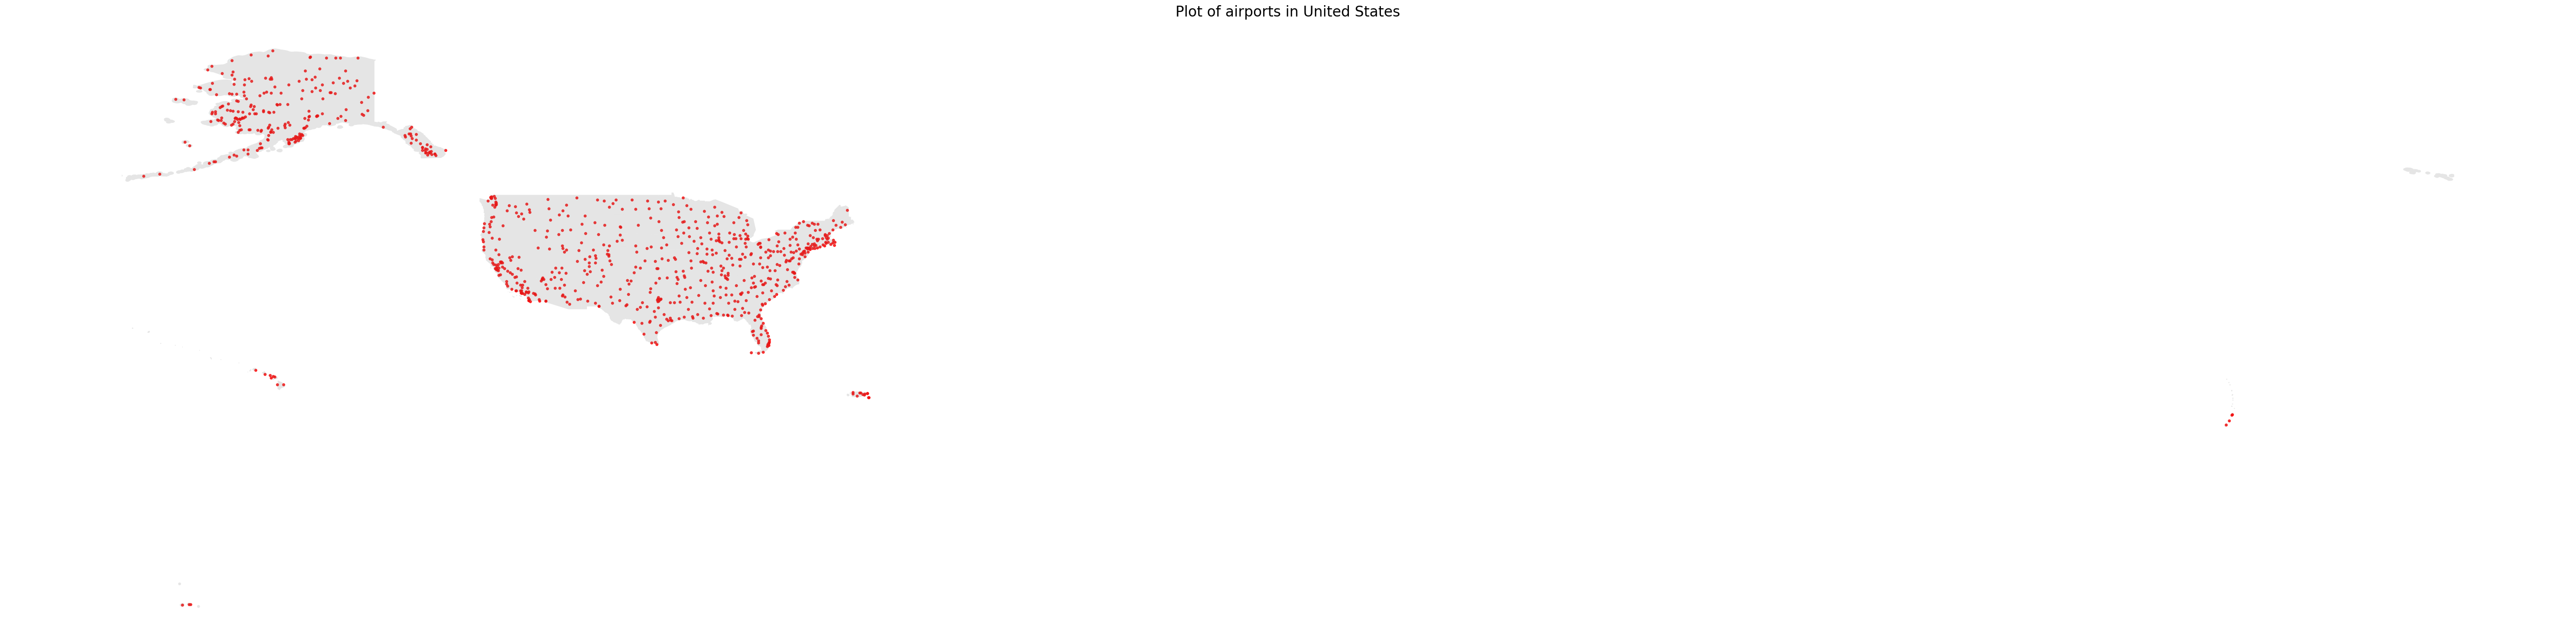

In [13]:
# plotting the nodes in the shape file of US
plt.style.use("default")
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(50,50))
base = shp_us.plot(ax=ax, color='gray', alpha=0.2)
geo_stations.plot(ax=base, marker="o", color="r", markersize=10,alpha=0.8, zorder=0)
_ = ax.axis('off')
ax.set_title("Plot of airports in United States",fontsize=20)
fig.tight_layout()
fig.savefig("../figures/us_airports_nodes.pdf".format(dir_path))

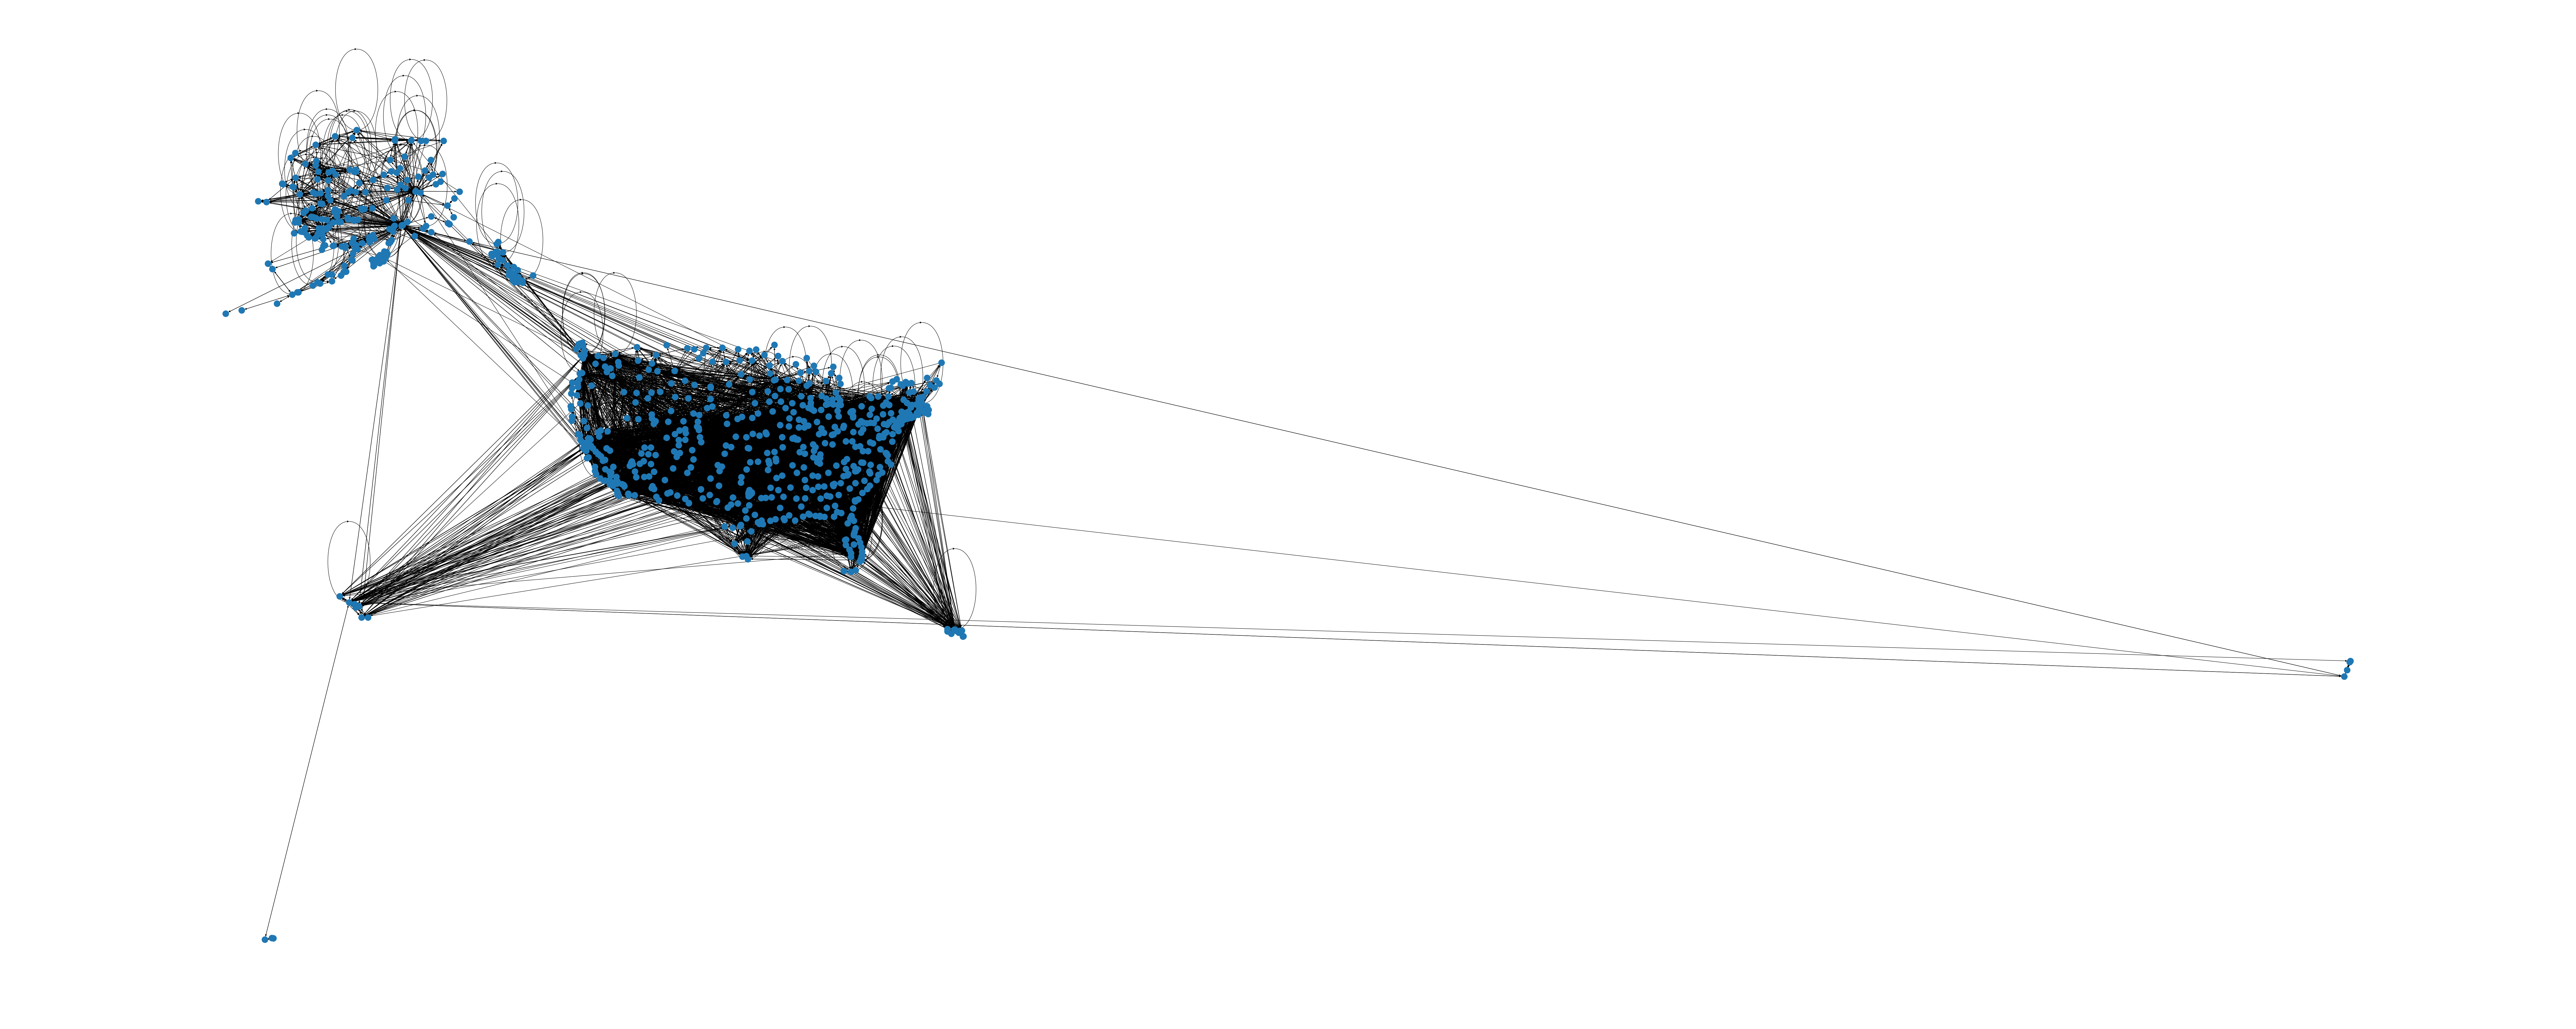

In [14]:
# displaying the network based on actual geographical placement of nodes
position_dict = {} # will contain the node coordinates
for item in list(geo_stations.station_ids):
  position_dict[item] = geo_stations[geo_stations.station_ids==item].geometry.values[0].x,geo_stations[geo_stations.station_ids==item].geometry.values[0].y
fig, ax = plt.subplots(1,1,figsize=(100,40))
nx.draw(G,pos=position_dict)
fig.tight_layout()
fig.savefig("../figures/us_airports_network_withposition.pdf".format(dir_path))

1


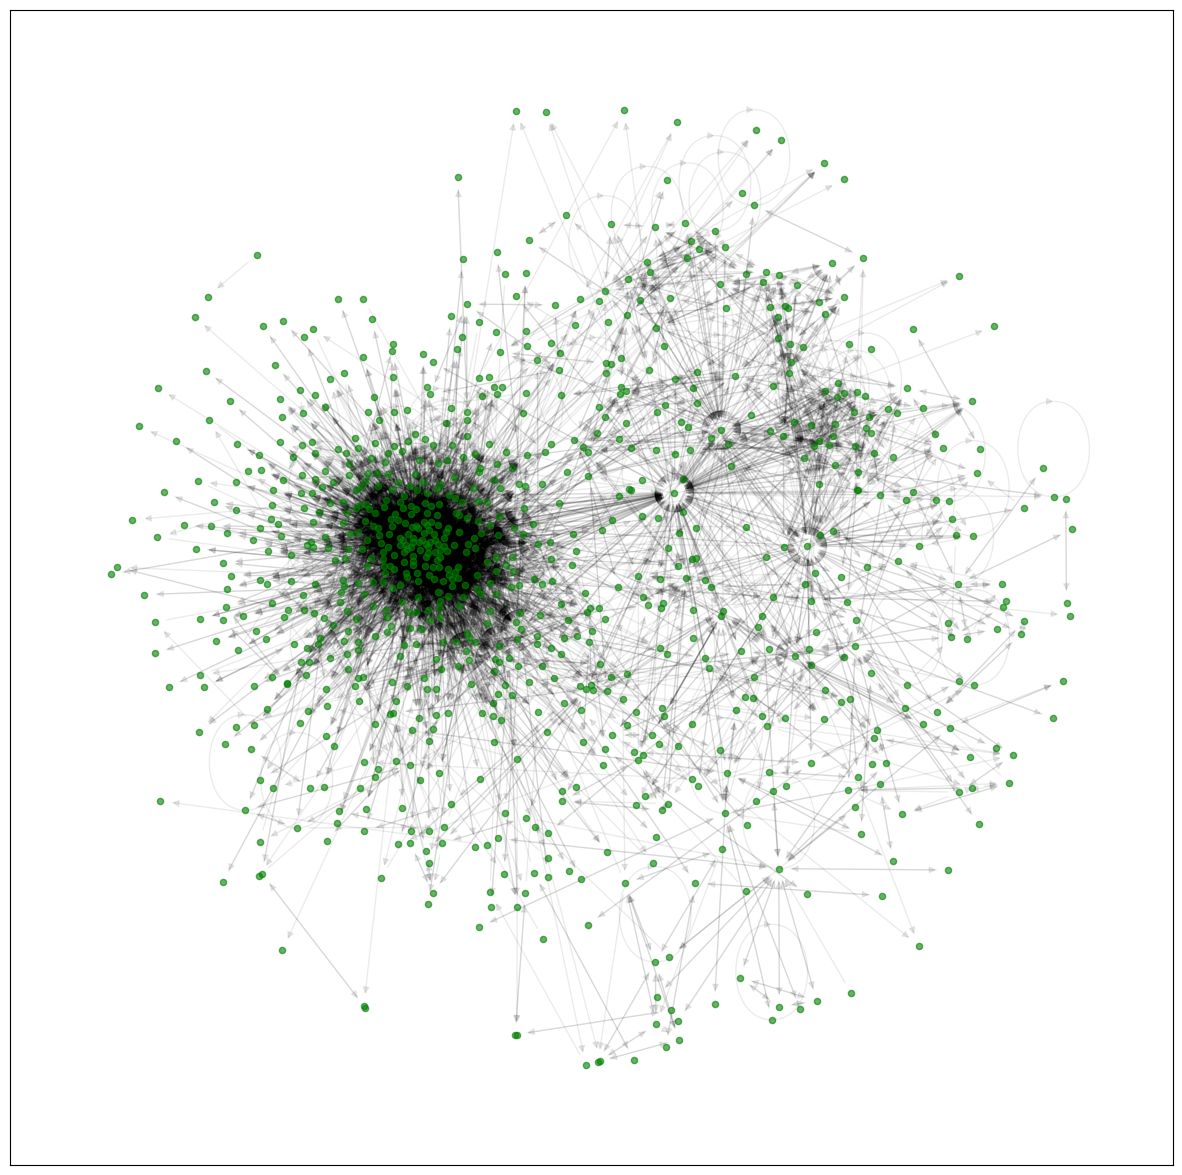

In [15]:
# displaying the network with optimal placement of nodes
airtraffic_helpers.plot_network(G,title="",edgealpha=0.08,node_dist=1,nodesize=20,savefig=False,figsize=(15,15))

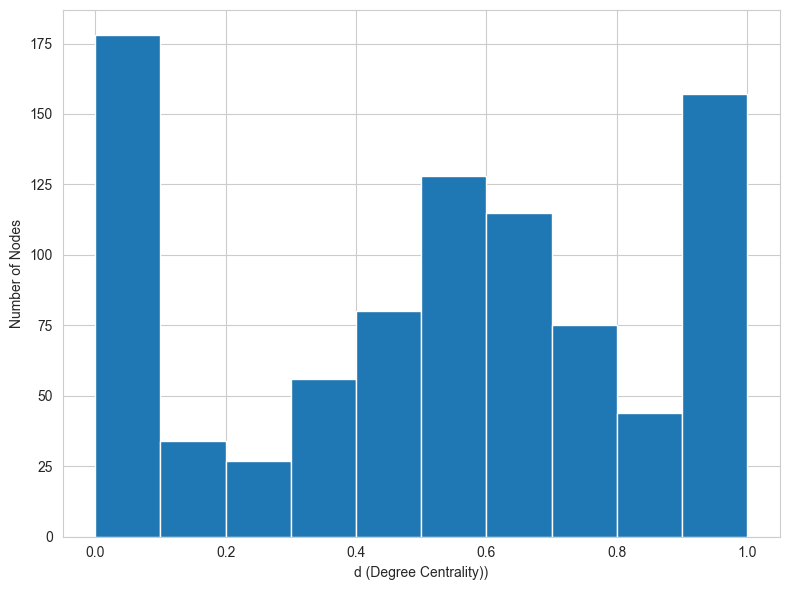

<Figure size 640x480 with 0 Axes>

In [ ]:
clustering = [c for _, c in nx.clustering(G).items()]

c = np.array(clustering)

plt.figure(figsize=(8,6))
plt.hist(c, edgecolor="white")

plt.ylabel("Number of Nodes")
plt.xlabel("Clustering Coefficient")

plt.tight_layout()
plt.show()

plt.savefig("../figures/clustering_coefficient_distribution.pdf".format(dir_path))

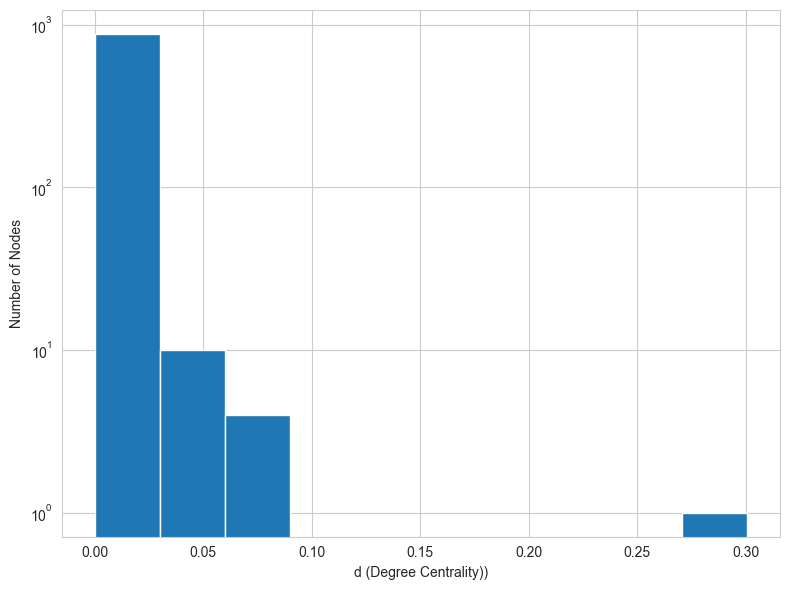

<Figure size 640x480 with 0 Axes>

In [26]:
degree_centrality = [c for _, c in nx.betweenness_centrality(G).items()]

dc = np.array(degree_centrality)

plt.figure(figsize=(8,6))
plt.hist(dc, edgecolor="white")

plt.yscale('log')

plt.ylabel("Number of Nodes")
plt.xlabel("d (Degree Centrality))")

plt.tight_layout()
plt.show()

plt.savefig("../figures/betweenness_centrality_distribution.pdf".format(dir_path))